
## Introduction and Overview of the Project
This tutorial demonstrates data augmentation: a technique to increase the diversity of your training *set* by applying random (but realistic) transformations such as image rotation. You will learn how to apply data augmentation in two ways. <br/>
First, you will use Keras Preprocessing Layers. <br/>
Next, you will use `tf.image`.

At the end of this project, you will try out an amazing Bonus Exercise!


Data augmentation is the increase of an existing training dataset's size and diversity without the requirement of manually collecting any new data. This augmented data is acquired by performing a series of preprocessing transformations to existing data, transformations which can include horizontal and vertical flipping, skewing, cropping, rotating, and more in the case of image data. Collectively, this augmented data is able to simulate a variety of subtly different data points, as opposed to just duplicating the same data. The subtle differences of these "additional" images should hopefully be enough to help train a more robust model.

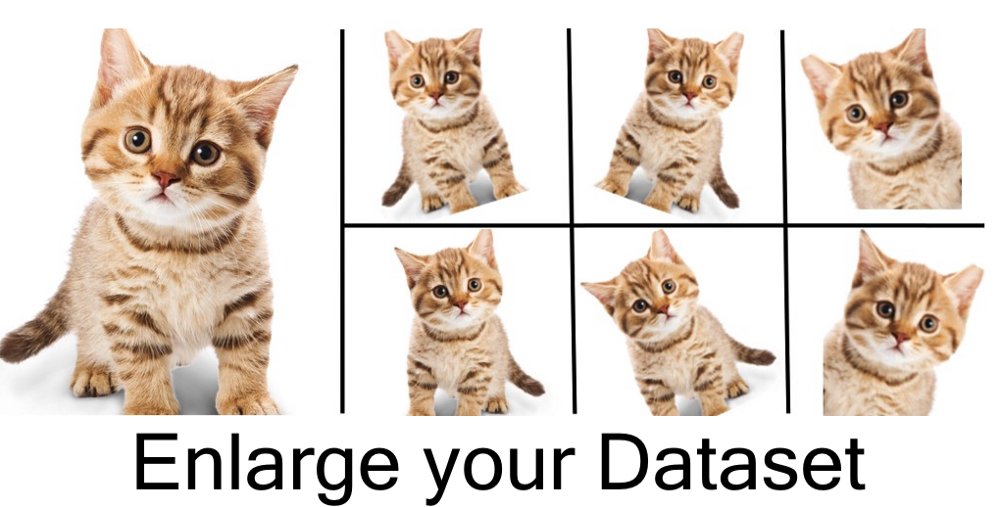![image.png](attachment:image.png)

In TensorFlow, data augmentation is accomplished using the ImageDataGenerator class. It is exceedingly simple to understand and to use. The entire dataset is looped over in each epoch, and the images in the dataset are transformed as per the options and values selected. These transformations are performed in-memory, and so no additional storage is required (though the save_to_dir parameter can be used to save augmented images to disk, if desired).

How we Apply image augmentation?

* rotation_range - degree range for random rotations;  <br/>
* width_shift_range - fraction of total width (if value < 1, as in this case) to randomly translate images horizontally; <br/>
* height_shift_range - fraction of total height (if value < 1, as in this case) to randomly translate images vertically; <br/>
* shear_range - shear angle in counter-clockwise direction in degrees, for shear transformations; <br/>
* zoom_range - range for random zoom; <br/>
* horizontal_flip - Boolean value for randomly flipping images horizontally; <br/>
* vertical_flip - Boolean value for randomly flipping images vertically; <br/>
* fill_mode - points outside the boundaries of input are filled according to either "constant", "nearest", "reflect" or "wrap"; <br/>

## Import Libraries and Setup the Dataset

### Import the Libraries

In [1]:
!pip install -q tf-nightly

     |████████████████████████████████| 451.9MB 36kB/s 
     |████████████████████████████████| 4.2MB 33.5MB/s 
     |████████████████████████████████| 471kB 50.0MB/s 
     |████████████████████████████████| 1.3MB 28.4MB/s 
     |████████████████████████████████| 5.5MB 34.7MB/s 
ERROR: tensorflow 2.5.0 has requirement grpcio~=1.34.0, but you'll have grpcio 1.38.0 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement keras-nightly~=2.5.0.dev, but you'll have keras-nightly 2.6.0.dev2021060800 which is incompatible.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

### Download the dataset


In [3]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


The flowers dataset has five classes.💐

In [6]:
num_classes = metadata.features['label'].num_classes
num_classes

5

Let's retrieve an image from the dataset and use it to demonstrate data augmentation.

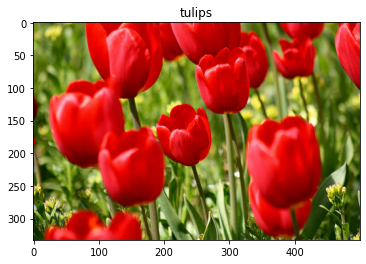

In [7]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

## Use Keras Layers for Rescaling, Augmentation

### Resizing and rescaling


In [8]:
IMG_SIZE = 180
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

📝Note: the rescaling layer above standardizes pixel values to `[0,1]`. If instead you wanted `[-1,1]`, you would write `Rescaling(1./127.5, offset=-1)`.


You can see the result of applying these layers to an image. 👀

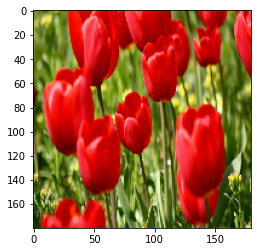

In [9]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

You can verify the pixels are in `[0-1]`.

In [10]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


### Data augmentation

You can use preprocessing layers for data augmentation as well.

Let's create a few preprocessing layers and apply them repeatedly to the same image.

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [12]:
# Add the image to a batch
image = tf.expand_dims(image, 0)

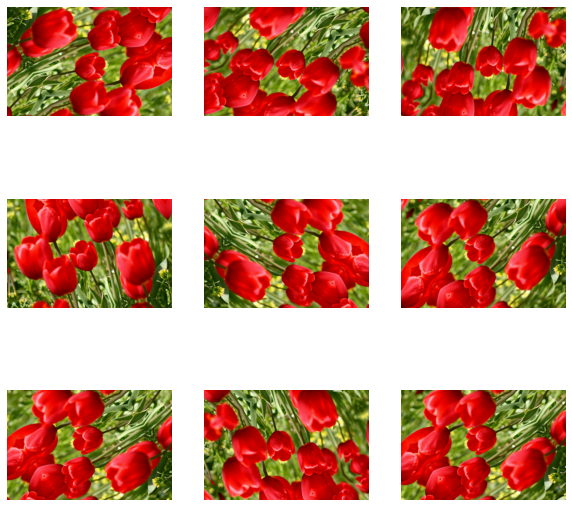

In [13]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

There are a variety of preprocessing [layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) you can use for data augmentation including `layers.RandomContrast`, `layers.RandomCrop`, `layers.RandomZoom`, and others.

## Use Keras for Preprocessing and Training

# Two options to use the preprocessing layers

There are two ways you can use these preprocessing layers, with important tradeoffs.

####  ⚙ Option 1: Make the preprocessing layers part of your model

In [14]:
model = tf.keras.Sequential([
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16,3,padding='same',activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model
])

There are two important  points to be aware of in this case 🙅‍♀️:

* Data augmentation will run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration.

* When you export your model using `model.save`, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). This can save you from the effort of having to reimplement that logic server-side.

📝Note: Data augmentation is inactive at test time so input images will only be augmented during calls to `model.fit` (not `model.evaluate` or `model.predict`).

####  ⚙ Option 2: Apply the preprocessing layers to your dataset

In [15]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

With this approach, you use `Dataset.map` to create a dataset that yields batches of augmented images. In this case 🙅‍♂️:

* Data augmentation will happen asynchronously on the CPU, and is non-blocking. You can overlap the training of your model on the GPU with data preprocessing, using `Dataset.prefetch`, shown below.
* In this case the prepreprocessing layers will not be exported with the model when you call `model.save`. You will need to attach them to your model before saving it or reimplement them server-side. After training, you can attach the preprocessing layers before export.


You can find an example of the first option in the [image classification](https://www.tensorflow.org/tutorials/images/classification) tutorial. Let's demonstrate the second option here.

### Apply the preprocessing layers to the datasets

Configure the train, validation, and test datasets with the preprocessing layers you created above. You will also configure the datasets for performance, using parallel reads and buffered prefetching to yield batches from disk without I/O become blocking. You can learn more dataset performance in the [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance) guide. 

📝Note: data augmentation should only be applied to the training set.

In [17]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [18]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

### Train a model

For completeness, you will now train a model using these datasets. This model has not been tuned for accuracy (the goal is to show you the mechanics).

In [21]:
model = tf.keras.Sequential([
                             
  # CREATE THE FIRST LAYER
  layers.Conv2D(16,3,padding='same',activation='relu'),
  layers.MaxPooling2D(),

  # CREATE THE SECOND LAYER 
  layers.Conv2D(32,3,padding='same',activation='relu'),
  layers.MaxPooling2D(),

  # CREATE THE THIRD LAYER
  layers.Conv2D(64,3,padding='same',activation='relu'),
  layers.MaxPooling2D(),

  # FLATTEN TO FEED INTO THE CNN
  layers.Flatten(),

  # FULLY CONNECTED CNN with 128 
  layers.Dense(128, activation='relu'),

  # CREATE THE OUTPUT LAYER
  layers.Dense(num_classes)
])

In [22]:
model.compile(optimizer= 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 90s 956ms/step - loss: 1.3397 - accuracy: 0.4063 - val_loss: 1.1476 - val_accuracy: 0.5504
Epoch 2/5
92/92 [==============================] - 86s 925ms/step - loss: 1.0784 - accuracy: 0.5610 - val_loss: 0.9971 - val_accuracy: 0.6185
Epoch 3/5
92/92 [==============================] - 86s 924ms/step - loss: 0.9849 - accuracy: 0.6042 - val_loss: 0.9279 - val_accuracy: 0.6512
Epoch 4/5
92/92 [==============================] - 86s 923ms/step - loss: 0.9317 - accuracy: 0.6253 - val_loss: 0.9252 - val_accuracy: 0.6512
Epoch 5/5
92/92 [==============================] - 85s 920ms/step - loss: 0.8719 - accuracy: 0.6614 - val_loss: 0.8595 - val_accuracy: 0.6866


In [24]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

12/12 [==============================] - 4s 274ms/step - loss: 0.8259 - accuracy: 0.6894
Accuracy 0.6893733143806458


###  Custom data augmentation

You can also create custom data augmenation layers. This tutorial shows two ways of doing so.<br/> First, you will create a `layers.Lambda` layer. This is a good way to write concise code.<br/> Next, you will write a new layer via [subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models), which gives you more control. <br/>Both layers will randomly invert the colors in an image, accoring to some probability. 

In [25]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [26]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

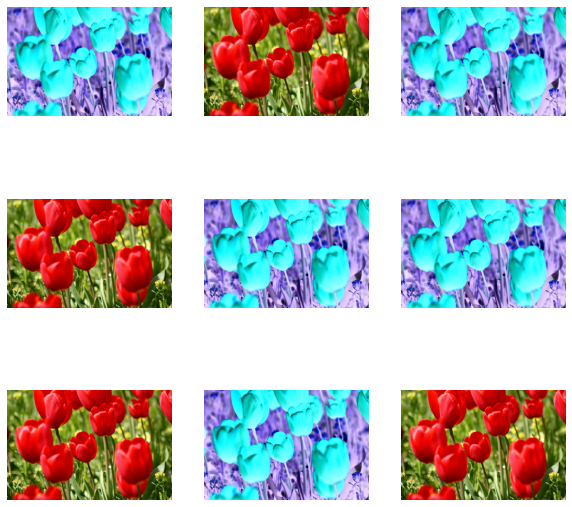

In [27]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

Next, implement a custom layer by [subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models).

In [28]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

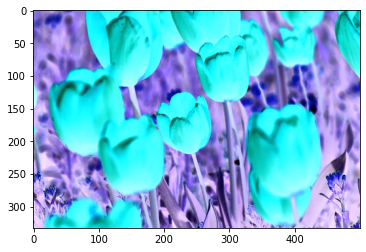

In [31]:
_ = plt.imshow(RandomInvert()(image)[0])

Both of these layers can be used as described in options 1 and 2 above.

##  Use Tensorflow to Apply Image Augmentation

The above `layers.preprocessing` utilities are convenient. For finer control, you can write your own data augmentation pipelines or layers using `tf.data` and `tf.image`. You may also want to check out [TensorFlow Addons Image: Operations](https://www.tensorflow.org/addons/tutorials/image_ops) and [TensorFlow I/O: Color Space Conversions](https://www.tensorflow.org/io/tutorials/colorspace)

Since the flowers dataset was previously configured with data augmentation, let's reimport it to start fresh.🌺

In [32]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Retrieve an image to work with.

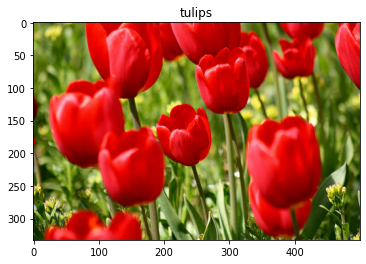

In [33]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

Let's use the following function to visualize and compare the original and augmented images side-by-side.

In [34]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

### Now, let's apply Data augmentation

### Flipping the image

Flip the image either vertically or horizontally.🚥

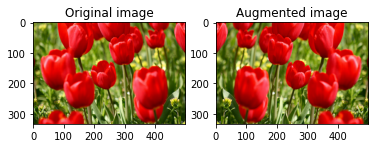

In [36]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

### Grayscale the image

Grayscale an image.

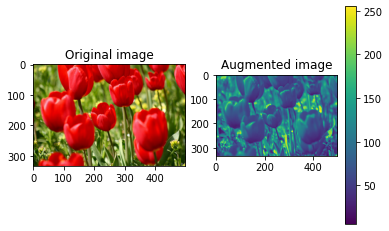

In [38]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

### Saturate the image

Saturate an image by providing a saturation factor.

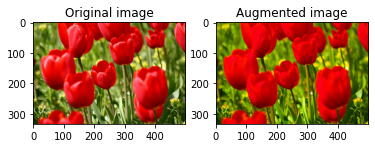

In [39]:
saturated = tf.image.adjust_saturation(image,3)
visualize(image, saturated)

### Change image brightness

Change the brightness of image by providing a brightness factor.🔅

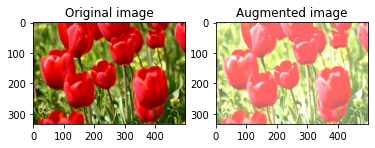

In [40]:
bright = tf.image.adjust_brightness(image,0.4)
visualize(image, bright)

### Center crop the image

Crop the image from center up to the image part you desire.✂

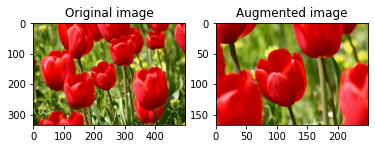

In [41]:
cropped = tf.image.central_crop(image,0.5)
visualize(image,cropped)

### Rotate the image

Rotate an image by 90 degrees

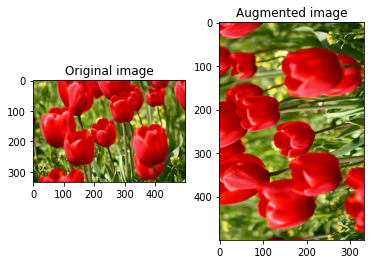

In [43]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

### Apply augmentation to a dataset

As before, apply data augmentation to a dataset using `Dataset.map`.

In [44]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

In [45]:
def augment(image,label):
  image, label = resize_and_rescale(image, label)
  # Add 6 pixels of padding
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6) 
   # Random crop back to the original size
  image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  image = tf.clip_by_value(image, 0, 1)
  return image, label

### Configure the datasets

In [46]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
) 

In [47]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [48]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

These datasets can now be used to train a model as shown previously.

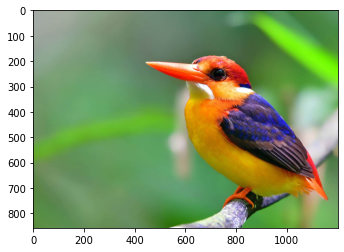

In [49]:
from keras.preprocessing.image import load_img
from matplotlib import pyplot
# upload your own image
img = load_img('bird.jpg')
# show the figure
pyplot.imshow(img)

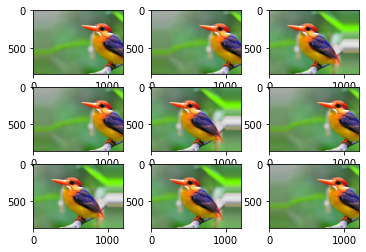

In [51]:
# example of horizontal shift image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img('bird.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(width_shift_range=[-200,200])
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

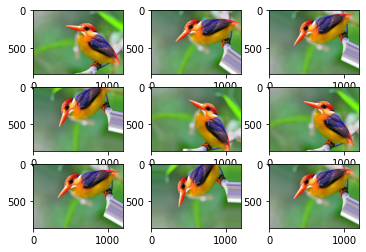

In [53]:
# example of random rotation image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img('bird.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=90)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

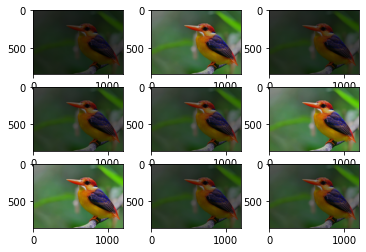

In [54]:
# example of brighting image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img('bird.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(brightness_range=[0.2,1.0])
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

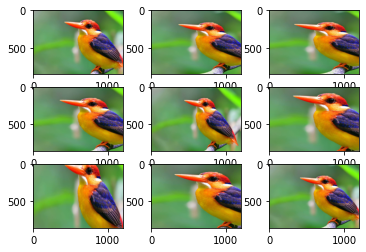

In [55]:
# example of zoom image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img('bird.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(zoom_range=[0.5,1.0])
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

1) What are the advantages of TensorFlow?

* It can be easily trained on CPU as well as GPU for distributed computing.
* It has auto differentiation capabilities.
* It has platform flexibility.
* It is easily customizable and open-source.
* It has advanced support for threads, asynchronous computations, and queues.

2) Describe the common steps to most TensorFlow algorithms?

* Import data, generate data, or setting a data-pipeline through placeholders.
* Feed the data through the computational graph.
* Evaluate output on the loss function.
* Use backpropagation to modify the variables.
* Repeat until stopping condition.